<a href="https://colab.research.google.com/github/s-mostafa-a/lung-cancer-segmentation/blob/master/using_wolny_package_for_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
!tar -xf ./drive/My\ Drive/Copy_Task06_Lung.tar -C ./

In [11]:
!pip install git+git://github.com/s-mostafa-a/niftidataset.git
!git clone https://github.com/wolny/pytorch-3dunet.git

  Cloning git://github.com/s-mostafa-a/niftidataset.git to /tmp/pip-req-build-voeke9_1
  Running command git clone -q git://github.com/s-mostafa-a/niftidataset.git /tmp/pip-req-build-voeke9_1
  Created wheel for niftidataset: filename=niftidataset-0.2.0-cp36-none-any.whl size=11872 sha256=f7cb46c3eb0f8447a527ea23690942b90af530ae0d60de00df078bb8bbf90bec
  Stored in directory: /tmp/pip-ephem-wheel-cache-jfe7zmir/wheels/90/80/c0/09c0a7dbe8a2902eeca8ebc007b7cbe2b5a06389d3f71d54f9
Successfully built niftidataset
fatal: destination path 'pytorch-3dunet' already exists and is not an empty directory.


In [12]:
!pip install hdbscan

In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('/content/pytorch-3dunet/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D
from pytorch3dunet.unet3d.losses import *
from pytorch3dunet.unet3d.metrics import *
from niftidataset import *
from torchvision import transforms as tvt
%matplotlib inline
%load_ext autoreload
%autoreload 2
train_dir = '/content/Task06_Lung/'
patch_sz = 110
tfms = tvt.Compose([RandomCrop3D(patch_sz), ToTensor(), Normalize(mean=[0],std=[1],is_3d=True)])
tds, vds = get_train_and_validation_from_one_directory(source_dir=train_dir+'imagesTr', target_dir=train_dir+'labelsTr', valid_pct=0.2, transform=tfms)
print(len(tds), len(vds))
from fastai import vision as faiv
idb = faiv.ImageDataBunch.create(tds, vds, bs=1, num_workers=1)


51 12


In [ ]:
import torch 
model = UNet3D(in_channels=1, out_channels=1, final_sigmoid=False)
metric = MeanIoU()
metric.__name__ = 'MeanIoU'
learner = faiv.Learner(idb, model, loss_func=DiceLoss(), metrics=[metric], opt_func=torch.optim.Adam)
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


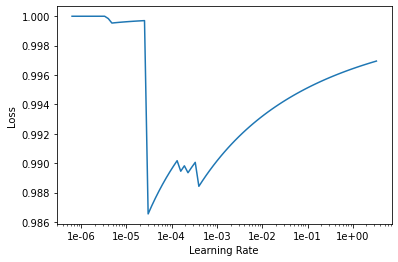

In [ ]:
learner.recorder.plot()

In [ ]:
# model(tds[0][0].view(tds[0][0].size()[0], -1))
# learner.predict(tds[0][0])
learner.fit_one_cycle(10, max_lr=slice(1e-03), pct_start=0.8)

epoch,train_loss,valid_loss,MeanIoU,time
0,0.998508,1.000000,0.000000,09:32
1,0.996173,1.000000,0.000000,09:26
2,0.996809,1.000000,0.000000,09:35
3,0.997406,1.000000,0.000000,09:27
4,0.997791,1.000000,0.000000,09:25


In [ ]:
learner.fit_one_cycle(10, max_lr=slice(1e-03), pct_start=0.8, a)

torch.Size([12, 1, 64, 64, 64])
torch.Size([12, 1, 64, 64, 64])


In [ ]:
import torch 
model = UNet3D(in_channels=1, out_channels=1, final_sigmoid=False)
metric = MeanIoU()
metric.__name__ = 'MeanIoU'
learner = faiv.Learner(idb, model, loss_func=nn.CrossEntropyLoss(weight=torch.Tensor([0.01,0.99])), metrics=[metric], opt_func=torch.optim.Adam)
learner.lr_find()



epoch,train_loss,valid_loss,MeanIoU,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: ignored

In [ ]:
from functools import partial


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
from torch.nn.modules.loss import _WeightedLoss
from torch import Tensor
from torch import nn
class MyOwnCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight: Tensor = None, size_average=None, ignore_index: int = -100,
                 reduce=None, reduction: str = 'mean') -> None:
        super(MyOwnCrossEntropyLoss, self).__init__(weight, size_average, reduce, reduction)
        self.ignore_index = ignore_index

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        return F.cross_entropy(input, target.squeeze(0).long(), weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction)


class MyWeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, ignore_index=-1):
        super(MyWeightedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, input, target):
        weight = self._class_weights(input)
        return F.cross_entropy(input, target.squeeze(0).long(), weight=weight, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights


import torch 
model = UNet3D(in_channels=1, out_channels=1, final_sigmoid=False)
metric = MeanIoU()
metric.__name__ = 'MeanIoU'
learner = faiv.Learner(idb, model, loss_func=MyWeightedCrossEntropyLoss(), metrics=[metric], opt_func=torch.optim.Adam)
learner.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


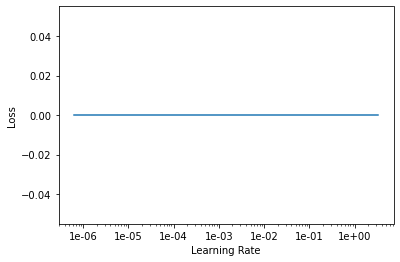

In [ ]:
learner.recorder.plot()

In [ ]:
from torch.nn import BCEWithLogitsLoss
import torch 
model = UNet3D(in_channels=1, out_channels=1, final_sigmoid=False)
metric = DiceCoefficient()
metric.__name__ = 'DiceCoefficient'
learner = faiv.Learner(idb, model, loss_func=BCEWithLogitsLoss(), metrics=[metric], opt_func=torch.optim.Adam)
learner.lr_find()

In [ ]:
learner.recorder.plot()

NameError: ignored

In [ ]:
learner.fit_one_cycle(10, max_lr=slice(1e+00), pct_start=0.8)

epoch,train_loss,valid_loss,DiceCoefficient,time
0,0.082808,2.526797,-0.000001,04:15
1,0.021780,2.822873,-0.000000,04:25


KeyboardInterrupt: ignored